In [1]:
!python --version

Python 3.8.10


A versão do python usada no Colab é 3.8.16

In [2]:
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 KB 16.5 MB/s eta 0:00:00


In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import pandas as pd
import numpy.linalg as la
import control as ct
from typing import Tuple

In [4]:
plt.style.use('ggplot')

In [5]:
# parâmetros físicos do sistema
g = 9.8 # m/s^2
M = 1. # kg
m = .1 # kg
l = .5 # m
F = 10 # N
condicoes_iniciais = [0, 0, -0.021, 0] # [x, x_dot, theta, theta_dot]

# limite superior e inferior permitido para esforço de controle
f_up = [F for _ in range(200)]
f_low = [-F for _ in range(200)]

# Controlador clássico PID

In [6]:
A = np.array(
  [
    [0, 1, 0, 0],
    [0, 0, ((-3*m*g)/(4*M + m)), 0],
    [0, 0, 0, 1],
    [0, 0, (3*(M+m)*g)/((4*M + m)*l), 0]
  ]
)


B = np.array(
  [
    [0],
    [(4)/(4*M + m)],
    [0],
    [(-3)/((4*M + m)*l)]
  ]
)

C = np.array(
  [
    [1,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0]
  ]
)

D = np.array(
  [
    [0],
    [0],
    [0],
    [0]
  ]
)


I = np.array(
  [
    [0],
    [0],
    [0],
    [0]
  ]
)

In [7]:
# polos do sistema
eigvalue, eigvector = np.linalg.eig(A)

eigvalue

array([ 0.        ,  0.        ,  3.97185218, -3.97185218])

In [8]:
# polos do sistema (forma 2)
sys = ct.StateSpace(A, B, C, D)

sys.poles()

array([ 0.        +0.j,  0.        +0.j,  3.97185218+0.j, -3.97185218+0.j])

In [9]:
# matriz T de controlabilidade
T = ct.ctrb(A, B)
T

array([[  0.        ,   0.97560976,   0.        ,   1.04937537],
       [  0.97560976,   0.        ,   1.04937537,   0.        ],
       [  0.        ,  -1.46341463,   0.        , -23.08625818],
       [ -1.46341463,   0.        , -23.08625818,   0.        ]])

In [10]:
# calcula o posto da matriz de controlabilidade
# se posto = 4 (numero de dimensoes do sistema) então ele é controlável
posto_T = la.matrix_rank(T)
posto_T

4

Calculo dos pólos dominantes dados os parâmetros do projeto MS (sobressinal) e Ts (tempo de acomodação)

In [11]:
def calculate_freq(MS: float, Ts: float) -> (float, float, float):
  """Return qsi, wn, wd."""
  aux = (np.log(MS))**2
  qsi = np.sqrt(aux/(aux + np.pi**2))

  wn = 4/(Ts*qsi)

  wd = wn*np.sqrt(1-qsi**2)

  return qsi, wn, wd

def calculate_polos(qsi: float, wn: float, wd: float) -> (float, complex):
  """Return dominant polos: -qsi*wn (+/-) j wd"""
  return -qsi*wn + complex(0,wd), -qsi*wn - complex(0,wd)


In [12]:
tests = [
    {'MS': .05, 'Ts': 1},
    {'MS': .08, 'Ts': 1.5},
    {'MS': .09, 'Ts': 1.5},
    {'MS': .10, 'Ts': 2},
    {'MS': .10, 'Ts': 2.2},
    {'MS': .10, 'Ts': 2.5},
    {'MS': .12, 'Ts': 2.5},
]

tests

[{'MS': 0.05, 'Ts': 1},
 {'MS': 0.08, 'Ts': 1.5},
 {'MS': 0.09, 'Ts': 1.5},
 {'MS': 0.1, 'Ts': 2},
 {'MS': 0.1, 'Ts': 2.2},
 {'MS': 0.1, 'Ts': 2.5},
 {'MS': 0.12, 'Ts': 2.5}]

In [13]:
# p1 e p2 são polos dominantes
data = {'MS': [], 'Ts': [], 'qsi': [], 'wn': [], 'wd': [], 'p1': [], 'p2': []}

for test in tests:
  MS = test.get("MS")
  Ts = test.get("Ts")

  qsi, wn, wd = calculate_freq(MS, Ts)

  p1, p2 = calculate_polos(qsi, wn, wd)

  data['MS'].append(MS)
  data['Ts'].append(Ts)
  data['qsi'].append(qsi)
  data['wn'].append(wn)
  data['wd'].append(wd)
  data['p1'].append(p1)
  data['p2'].append(p2)


In [14]:
df = pd.DataFrame(data)
df.round(4)

,MS,Ts,qsi,wn,wd,p1,p2
0,0.05,1.0,0.6901,5.7962,4.1948,-4.000000+4.194758j,-4.000000-4.194758j
1,0.08,1.5,0.6266,4.2559,3.3169,-2.666667+3.316896j,-2.666667-3.316896j
2,0.09,1.5,0.6083,4.3836,3.4791,-2.666667+3.479140j,-2.666667-3.479140j
3,0.10,2.0,0.5912,3.3832,2.7288,-2.000000+2.728753j,-2.000000-2.728753j
4,0.10,2.2,0.5912,3.0756,2.4807,-1.818182+2.480684j,-1.818182-2.480684j
5,0.10,2.5,0.5912,2.7066,2.1830,-1.600000+2.183002j,-1.600000-2.183002j
6,0.12,2.5,0.5594,2.8601,2.3707,-1.600000+2.370719j,-1.600000-2.370719j


Os outros dois polos precisam ser colocados em outro um ponto à esquerda bem distante dos polos dominantes. Será considerado uma distância de 8x dos valores polos.

In [15]:
distance = 8
df['p3'] = np.real(df.p2) * distance
df['p4'] = np.imag(df.p2) * distance

df.round(4)

,MS,Ts,qsi,wn,wd,p1,p2,p3,p4
0,0.05,1.0,0.6901,5.7962,4.1948,-4.000000+4.194758j,-4.000000-4.194758j,-32.0000,-33.5581
1,0.08,1.5,0.6266,4.2559,3.3169,-2.666667+3.316896j,-2.666667-3.316896j,-21.3333,-26.5352
2,0.09,1.5,0.6083,4.3836,3.4791,-2.666667+3.479140j,-2.666667-3.479140j,-21.3333,-27.8331
3,0.10,2.0,0.5912,3.3832,2.7288,-2.000000+2.728753j,-2.000000-2.728753j,-16.0000,-21.8300
4,0.10,2.2,0.5912,3.0756,2.4807,-1.818182+2.480684j,-1.818182-2.480684j,-14.5455,-19.8455
5,0.10,2.5,0.5912,2.7066,2.1830,-1.600000+2.183002j,-1.600000-2.183002j,-12.8000,-17.4640
6,0.12,2.5,0.5594,2.8601,2.3707,-1.600000+2.370719j,-1.600000-2.370719j,-12.8000,-18.9657


Agora será identifica as matrizes de ganho K para cada requisito do sistema.

In [16]:
def calculate_gain_matrix_k(p1: complex, p2: complex, p3: complex, p4: complex) -> np.array:
  polos = np.array([p1, p2, p3, p4])
  K = signal.place_poles(A, B, polos).gain_matrix

  return K


In [17]:
lines = df.shape[0]
k_list = []

for line in range(lines):
  req = df.iloc[line]
  k_list.append(calculate_gain_matrix_k(req.p1, req.p2, req.p3, req.p4))

df['k'] = k_list


In [18]:
df[['MS', 'Ts', 'k']].round(1)

,MS,Ts,k
0,0.0,1.0,"[[-2515.595552990403, -752.5976388512746, -280..."
1,0.1,1.5,"[[-714.949653026096, -270.9731104898045, -1061..."
2,0.1,1.5,"[[-795.5719935252798, -286.6897194805734, -113..."
3,0.1,2.0,"[[-278.7647699937282, -127.6109150608922, -546..."
4,0.1,2.2,"[[-190.40008878746212, -95.8759692418409, -426..."
5,0.1,2.5,"[[-114.18204978942956, -65.33678851117598, -31..."
6,0.1,2.5,"[[-138.47012651540015, -72.28625274602746, -34..."


In [19]:
for line in range(lines):
  req = df.iloc[line]
  MS, Ts, k = req.MS, req.Ts, req.k

  print(f'MS: {MS} | Ts: {Ts}\n\nK: {np.round(k, 0)}\n\n\n###\n\n\n')

MS: 0.05 | Ts: 1.0

K: [[-2516.  -753. -2803.  -552.]]


###



MS: 0.08 | Ts: 1.5

K: [[ -715.  -271. -1061.  -217.]]


###



MS: 0.09 | Ts: 1.5

K: [[ -796.  -287. -1139.  -228.]]


###



MS: 0.1 | Ts: 2.0

K: [[-279. -128. -547. -114.]]


###



MS: 0.1 | Ts: 2.2

K: [[-190.  -96. -427.  -90.]]


###



MS: 0.1 | Ts: 2.5

K: [[-114.  -65. -311.  -66.]]


###



MS: 0.12 | Ts: 2.5

K: [[-138.  -72. -344.  -72.]]


###





In [20]:
mask = (df.MS == 0.1) & (df.Ts == 2.2) # matriz de ganho K5
K = df[mask].k.iloc[0]

print(K.round(0))

[[-190.  -96. -427.  -90.]]


In [21]:
A_new = A - B*K

original_system = signal.StateSpace(A, B, C, D)
system_with_gain = signal.StateSpace(A_new, B, C, D)

t_noctl,y_noctl = original_system.step()
t_ctl, y_ctl = system_with_gain.step()

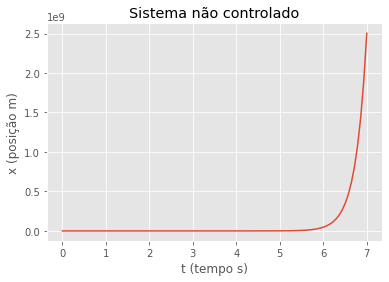

In [22]:
plt.plot(t_noctl, y_noctl[:, [0]])

plt.title('Sistema não controlado')
plt.ylabel('x (posição m)')
plt.xlabel('t (tempo s)')
plt.show()

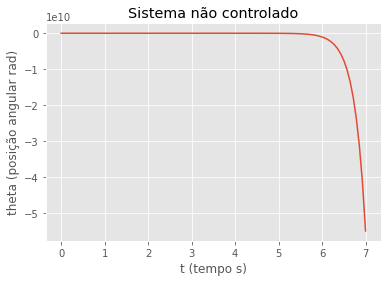

In [23]:
plt.plot(t_noctl, y_noctl[:, [2]])

plt.title('Sistema não controlado')
plt.ylabel('theta (posição angular rad)')
plt.xlabel('t (tempo s)')
plt.show()

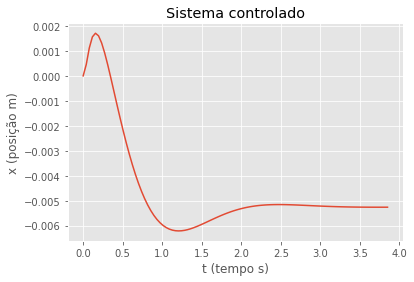

In [24]:
plt.plot(t_ctl, y_ctl[:, [0]])

plt.title('Sistema controlado')
plt.ylabel('x (posição m)')
plt.xlabel('t (tempo s)')
plt.show()

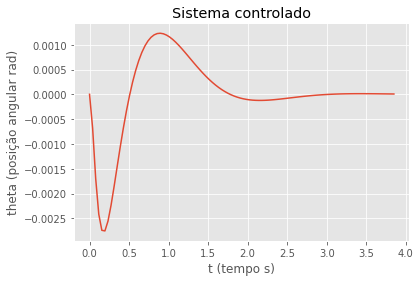

In [25]:
plt.plot(t_ctl, y_ctl[:, [2]])

plt.title('Sistema controlado')
plt.ylabel('theta (posição angular rad)')
plt.xlabel('t (tempo s)')
plt.show()

In [26]:
def model(y, t):
  x_dot = y[1]
  
  x_ddot = 4*F/(4*M + m) - 3*m*g*l*y[2]/(4*M + m)

  theta_dot = y[3]

  theta_ddot = 3*(M + m)*g*y[2]/((4*M + m)*l) - 3*F/((4*M + m)*l)

  return x_dot, x_ddot, theta_dot, theta_ddot

In [27]:
t3 = np.linspace(0, 2, num = 200)
y = odeint(func = model, y0 = [0, 0, 0, 0], t = t3)

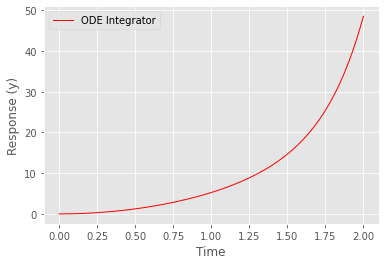

In [28]:
plt.figure(1)
plt.plot(t3, y[:, [0]], 'r-', linewidth = 1, label = 'ODE Integrator')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='best')
plt.show()

In [29]:
def model_with_gain(y, t, K, u):
  # calculo u = Kx, usando x anterior

  x_dot = y[1]
  x_ddot = 4*u/(4*M + m) - 3*m*g*y[2]/(4*M + m)
  theta_dot = y[3]
  theta_ddot = 3*(M + m)*g*y[2]/((4*M + m)*l) - 3*u/((4*M + m)*l)
  
  return x_dot, x_ddot, theta_dot, theta_ddot

In [30]:
t4 = np.linspace(0, 5, num = 200)
ku_listed0 = []

y0 = condicoes_iniciais

y2 = np.zeros((len(t4), 1, 4))

for i in range(len(t4) -1):
  ts = [t4[i], t4[i + 1]]
  u = -K @ y0
  ku_listed0.append(u)
  y2[i] = y0
  y8 = odeint(func = model_with_gain, y0 = y0, t = ts, args = (K, u[0]))
  y0 = y8[1]

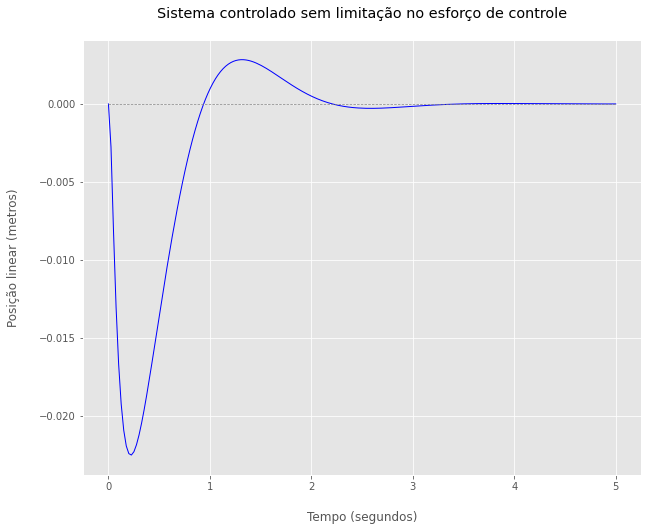

In [31]:
plt.figure(2, figsize = (10, 8))
plt.plot(t4, y2[:, [0], 0], 'b-', linewidth = 1)
plt.plot(t4, t4*0, '--', color = 'gray', linewidth = .7)
plt.xlabel('\nTempo (segundos)')
plt.ylabel('Posição linear (metros)\n')
plt.title('Sistema controlado sem limitação no esforço de controle\n')
plt.show()

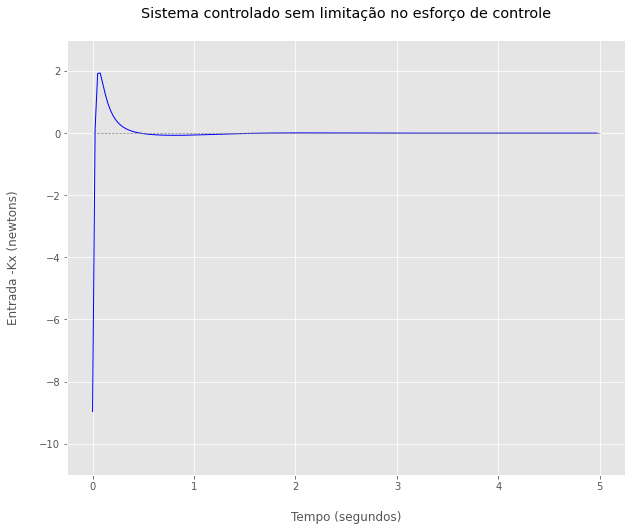

In [32]:
plt.figure(2, figsize = (10, 8))
plt.plot(t4[:199], ku_listed0, 'b-', linewidth = 1)
plt.plot(t4, t4*0, '--', color = 'gray', linewidth = .7)
plt.ylim([-11, 3])
plt.title('Sistema controlado sem limitação no esforço de controle\n')
plt.xlabel('\nTempo (segundos)')
plt.ylabel('Entrada -Kx (newtons)\n')
plt.show()

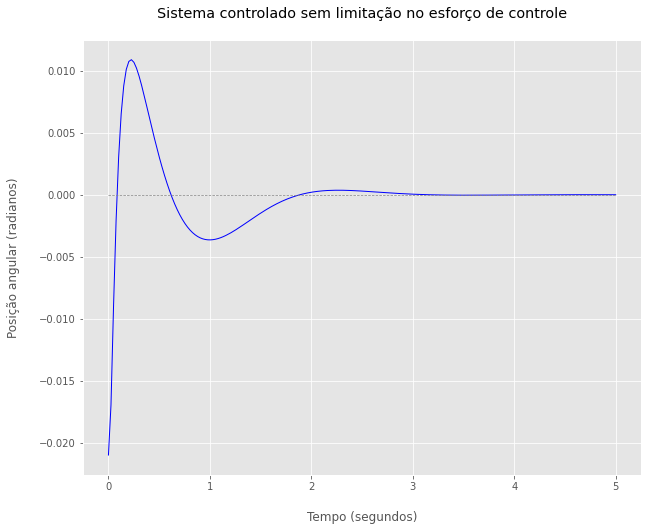

In [33]:
plt.figure(2, figsize = (10, 8))
plt.plot(t4, y2[:, [0], 2], 'b-', linewidth = 1)
plt.plot(t4, t4*0, '--', color = 'gray', linewidth = .7)
plt.title('Sistema controlado sem limitação no esforço de controle\n')
plt.xlabel('\nTempo (segundos)')
plt.ylabel('Posição angular (radianos)\n')
plt.show()

In [34]:
def model_with_gain_open(y, t, K, u):
  if u > 0:
    u = F
  elif u <= 0:
    u = -F

  x_dot = y[1]
  x_ddot = 4*u/(4*M + m) - 3*m*g*y[2]/(4*M + m)
  theta_dot = y[3]
  theta_ddot = 3*(M + m)*g*y[2]/((4*M + m)*l) - 3*u/((4*M + m)*l)
  
  return x_dot, x_ddot, theta_dot, theta_ddot

In [35]:
def plot_esforco_controle(ku: list, tempo: list, title: str, num_plot: int = 1) -> None:
  plt.figure(3, figsize = (10, 8))
  plt.plot(tempo, f_low, 'b-', linewidth = 1, label = 'Limite inferior de atuação exigido')
  plt.plot(tempo, f_up, 'b-', linewidth = 1, label = 'Limite superior de atuação exigido')
  plt.plot(tempo, ku, 'r-', linewidth = 1, label = '-Kx')
  plt.title(title)
  plt.xlabel('Tempo (segundos)')
  plt.ylabel('Força de entrada (newtons)')
  plt.legend(loc = 'best')
  plt.show()

Plotando o sinal de controle (entrada) para todos os ganhos.

In [36]:
def calculate_x_ku(K: np.array) -> Tuple[np.array, list, np.array]:
  ku = [] # entrada controlada
  f_limite = []

  tempo = np.linspace(0, 4, num = 200)
  y0 = condicoes_iniciais
  x = np.zeros((len(tempo), 1, 4)) # [x, x_dot, theta, theta_dot]

  for i in range(len(tempo) - 1):
      ts = [tempo[i], tempo[i + 1]]
      u = -K @ y0 # entrada controlada
      ku.append(u)

      if u > 0:
        f = F
      elif u <= 0:
        f = -F

      f_limite.append(f)
      x[i] = y0
      y3 = odeint(func = model_with_gain_open, y0 = y0, t = ts, args = (K, u[0]))
      y0 = y3[1]

  x[199] = x[198]
  f_limite.append(f_limite[198])
  ku.append(ku[198])

  return x, ku, tempo

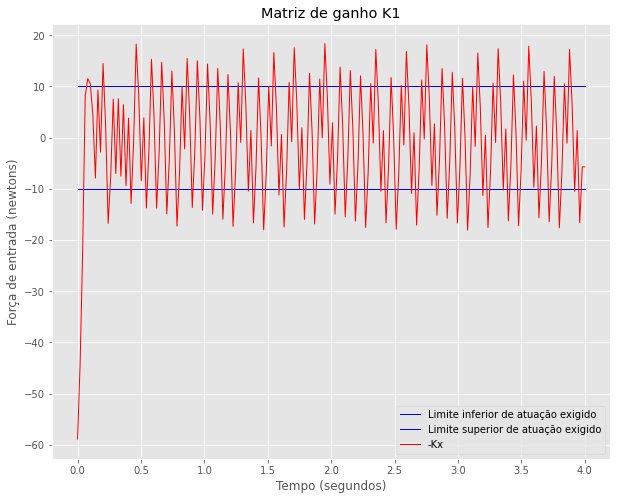

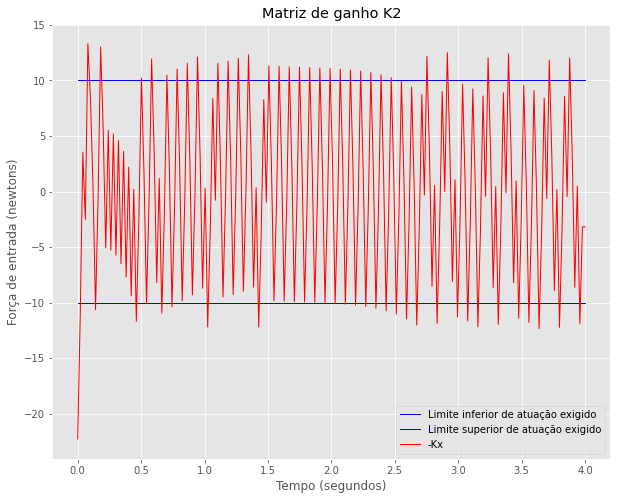

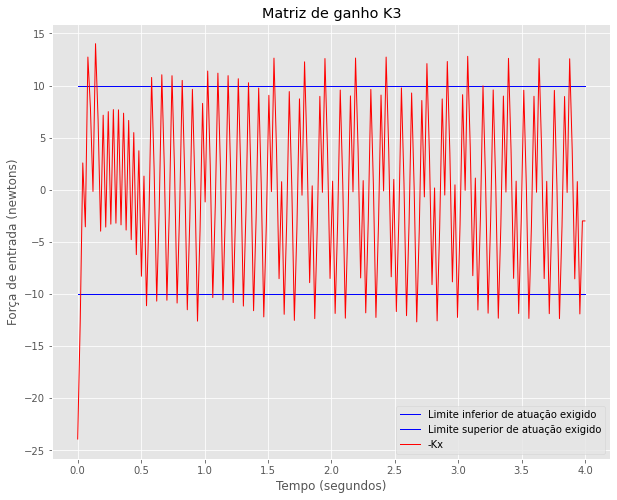

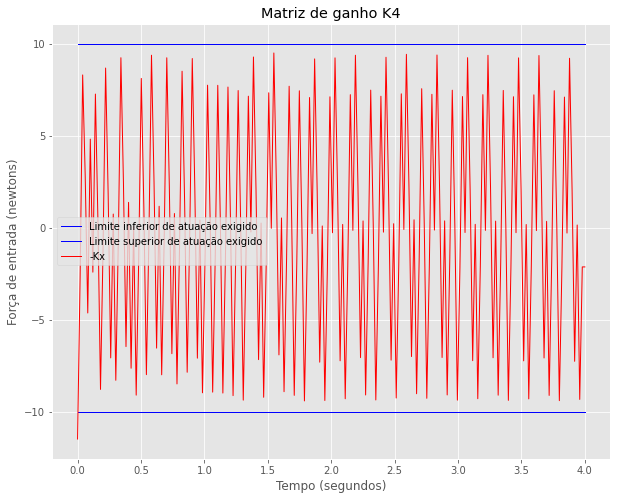

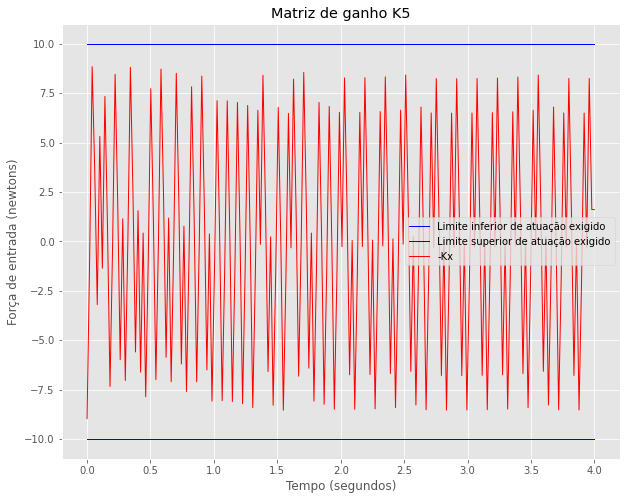

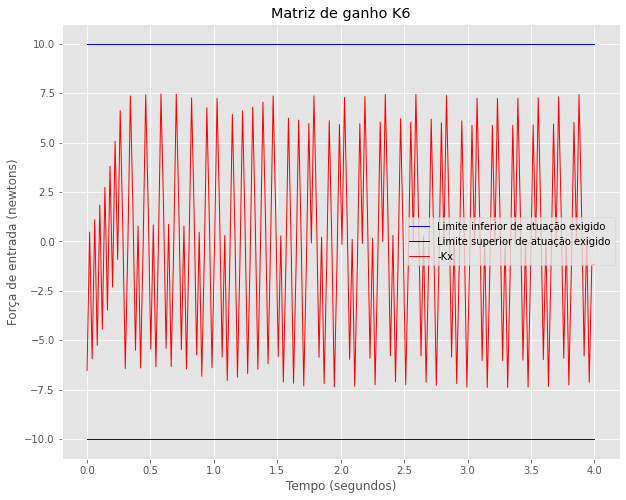

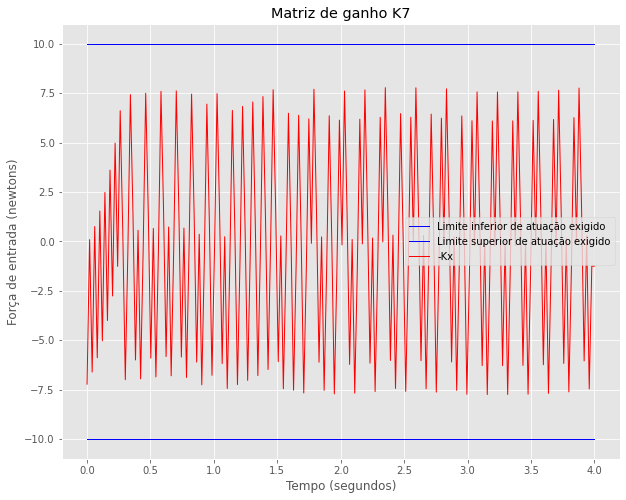

In [37]:
# plotando os gráficos que verificam se o esforço de controle ultrapassa |10|

ks = []

for i in range(df.shape[0]):
  k_matrix = df.k.iloc[i]
  x, ku, t = calculate_x_ku(k_matrix)

  plot_esforco_controle(ku, t, f'Matriz de ganho K{i + 1}', i)

  ks.append({'ku': ku, 't': t})

É possível notar que K5 é o ganho mais adequado pois é o que possui os menores requisitos de projeto (sobreelevação e tempo de subida) enquanto o esforço de controle não ultrapassa o módulo de 10 newtons. 

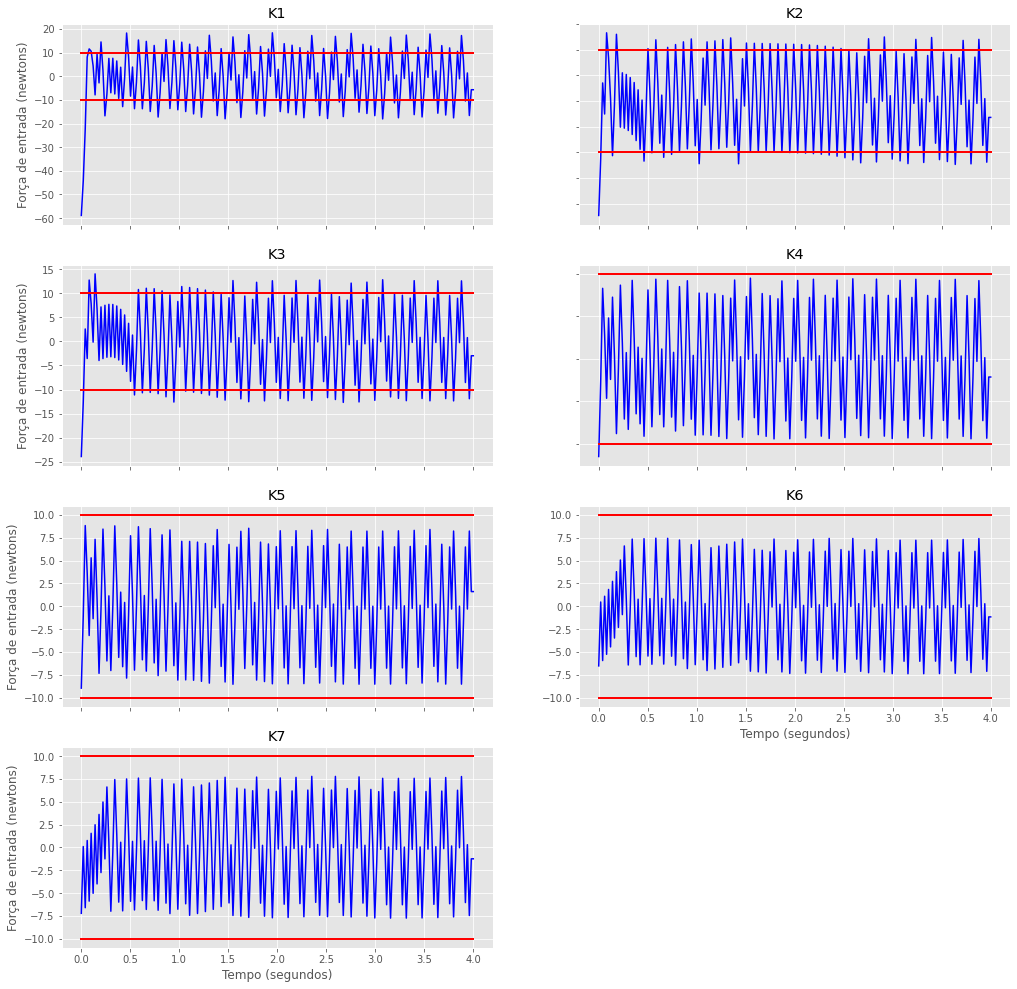

In [38]:
fig, axs = plt.subplots(4, 2, figsize=(17, 17))
fig.delaxes(axs[3, 1])

axs[0, 0].plot(ks[0].get('t'), ks[0].get('ku'), color = 'blue')
axs[0, 0].plot(ks[0].get('t'), f_low, 'r-', linewidth = 2)
axs[0, 0].plot(ks[0].get('t'), f_up, 'r-', linewidth = 2)
axs[0, 0].set_title('K1')

axs[0, 1].plot(ks[1].get('t'), ks[1].get('ku'), color = 'blue')
axs[0, 1].plot(ks[1].get('t'), f_low, 'r-', linewidth = 2)
axs[0, 1].plot(ks[1].get('t'), f_up, 'r-', linewidth = 2)
axs[0, 1].set_title('K2')

axs[1, 0].plot(ks[2].get('t'), ks[2].get('ku'), color = 'blue')
axs[1, 0].plot(ks[2].get('t'), f_low, 'r-', linewidth = 2)
axs[1, 0].plot(ks[2].get('t'), f_up, 'r-', linewidth = 2)
axs[1, 0].set_title('K3')

axs[1, 1].plot(ks[3].get('t'), ks[3].get('ku'), color = 'blue')
axs[1, 1].plot(ks[3].get('t'), f_low, 'r-', linewidth = 2)
axs[1, 1].plot(ks[3].get('t'), f_up, 'r-', linewidth = 2)
axs[1, 1].set_title('K4')

axs[2, 0].plot(ks[4].get('t'), ks[4].get('ku'), color = 'blue')
axs[2, 0].plot(ks[4].get('t'), f_low, 'r-', linewidth = 2)
axs[2, 0].plot(ks[4].get('t'), f_up, 'r-', linewidth = 2)
axs[2, 0].set_title('K5')

axs[2, 1].plot(ks[5].get('t'), ks[5].get('ku'), color = 'blue')
axs[2, 1].plot(ks[5].get('t'), f_low, 'r-', linewidth = 2)
axs[2, 1].plot(ks[5].get('t'), f_up, 'r-', linewidth = 2)
axs[2, 1].set_title('K6')

axs[3, 0].plot(ks[6].get('t'), ks[6].get('ku'), color = 'blue')
axs[3, 0].plot(ks[6].get('t'), f_low, 'r-', linewidth = 2)
axs[3, 0].plot(ks[6].get('t'), f_up, 'r-', linewidth = 2)
axs[3, 0].set_title('K7')

for num, ax in enumerate(axs.flat):
    if num == 5:
      ax.set(xlabel='Tempo (segundos)')
    else:
      ax.set(xlabel='Tempo (segundos)', ylabel='Força de entrada (newtons)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for num, ax in enumerate(axs.flat):
    if num != 5:
      ax.label_outer()

In [39]:
  k_matrix = df.k.iloc[4] # selecionando K5
  x, ku, t = calculate_x_ku(k_matrix)

In [40]:
def plot_variable(x: list, y: list, fig_number: int, y_label: str, title: str) -> None:
  plt.figure(fig_number, figsize = (10, 8))
  plt.plot(x, y, 'b-', linewidth = 1)
  plt.plot(x, x*0, '--', color = 'gray', linewidth = .7)
  plt.xlabel('\nTempo (segundos)')
  plt.ylabel(f'{y_label}\n')
  plt.title(f'{title}\n')
  plt.show()

In [41]:
position = x[:, [0], 0]
veloc_lin = x[:, [0], 1]
theta = x[:, [0], 2]
theta_dot = x[:, [0], 3]

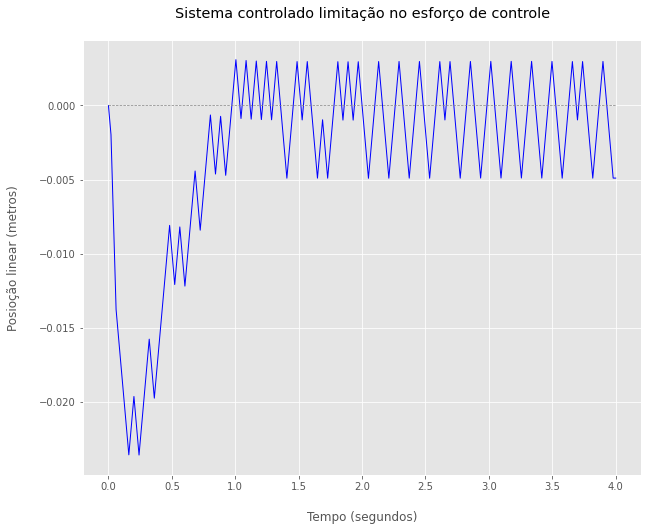

In [42]:
title = 'Sistema controlado limitação no esforço de controle'
plot_variable(t, position, 1, 'Posioção linear (metros)', title)

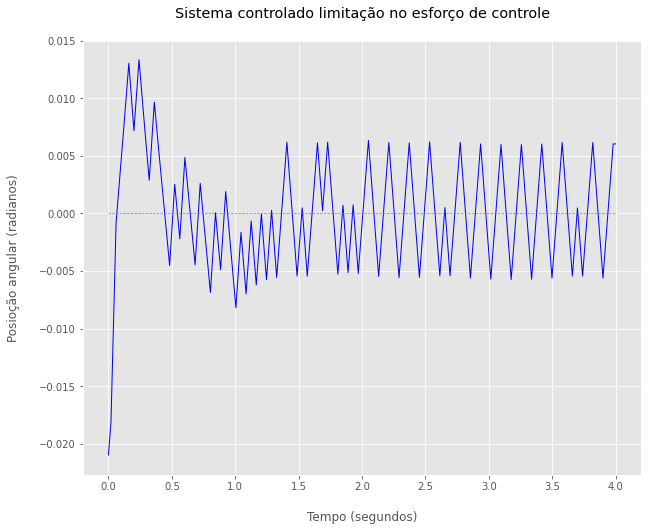

In [43]:
title = 'Sistema controlado limitação no esforço de controle'
plot_variable(t, theta, 2, 'Posioção angular (radianos)', title)

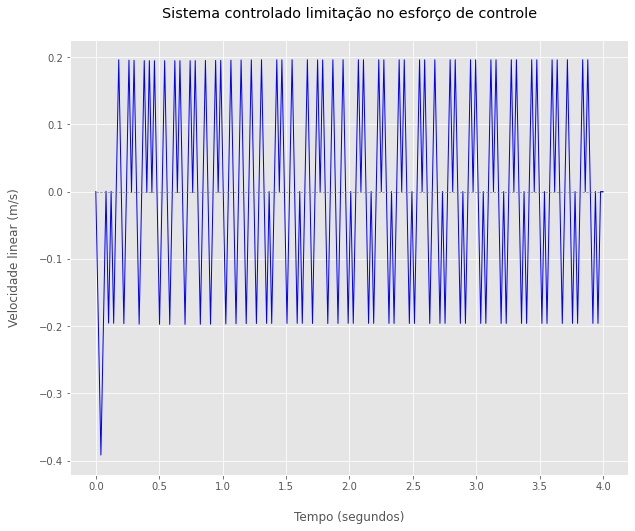

In [44]:
title = 'Sistema controlado limitação no esforço de controle'
plot_variable(t, veloc_lin, 3, 'Velocidade linear (m/s)', title)

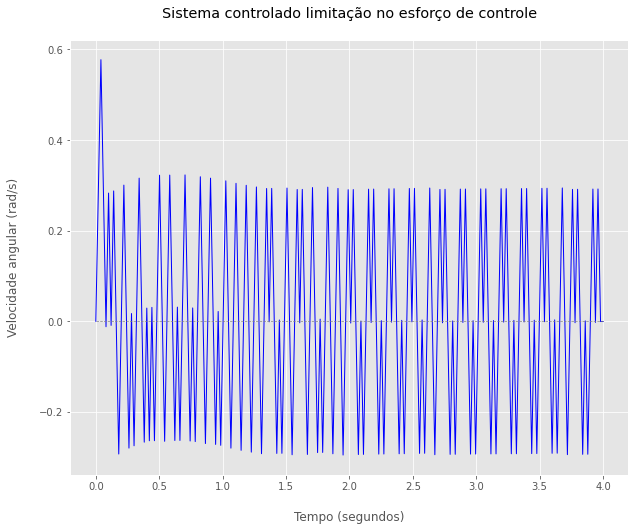

In [45]:
title = 'Sistema controlado limitação no esforço de controle'
plot_variable(t, theta_dot, 3, 'Velocidade angular (rad/s)', title)

In [53]:
data = {
    'tempo': t,
    'theta': theta.reshape((200,)),
    'x': position.reshape((200,))
}

In [54]:
df_pid = pd.DataFrame(data)
df_pid.to_csv('responses_pid.csv')

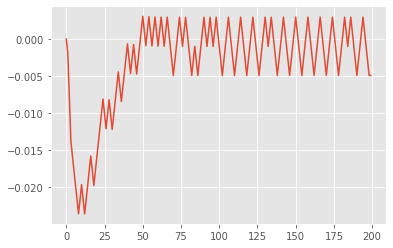

In [57]:
df_pid.x.plot()